<a href="https://colab.research.google.com/github/steflhermitte/EO-Notebooks/blob/master/PythonProgramming/RS_Notebook2_Loading_RS_data_in_python_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


[<img src="https://raw.githubusercontent.com/mbakker7/exploratory_computing_with_python/master/tudelft_logo.png" width="200" align='right'>](https://www.tudelft.nl/citg/over-faculteit/afdelingen/geoscience-remote-sensing/staff/scientific-staff/dr-stef-lhermitte)


# Loading remote sensing data in python 
*Created by Stef Lhermitte (s.lhermitte at tudelft.nl / [@steflhermitte](https://twitter.com/StefLhermitte) | www.earthmapps.io)*

*with inspiration and fragments from:*

* [geemap.org](https://geemap.org/)
* [Google Earth Engine guide](https://developers.google.com/earth-engine/guides)
* [rasterio](https://rasterio.readthedocs.io/en/latest/)


[![Twitter](https://img.shields.io/twitter/url/https/twitter.com/cloudposse.svg?style=social&label=%20%40steflhermitte)](https://twitter.com/steflhermitte)


## Before you start
Before starting this notebook make sure that you installed the necessary packages (see [Python installation example notebook](https://colab.research.google.com/drive/1MccJkybH3jEDeQ8GkU7NmtbXP8ZE4V5M?usp=sharing)). For your local computer, you only need to install the packages once and you won't need the next cell. For Colab, you need to run the following installation steps every time you start a new notebook and restart the environment afterwards. 

In [2]:
!apt-get install libproj-dev proj-data proj-bin
!apt-get install libgeos-dev
!pip install cython
!pip install git+https://github.com/SciTools/cartopy.git --no-binary cartopy
!apt-get -qq install python-cartopy python3-cartopy
!pip uninstall -y shapely    # cartopy and shapely aren't friends (early 2020)
!pip install shapely --no-binary shapely
!pip uninstall -y shapely # cartopy and shapely aren't friends (early 2020) 
!pip install shapely --no-binary shapely
!pip install matplotlib-scalebar
!pip install pyepsg
!pip install owslib
!pip install scikit-learn
!pip install geopandas
!pip install rasterio
!pip install geemap
from google.colab import drive
drive.mount('/content/drive')

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libproj-dev is already the newest version (4.9.3-2).
libproj-dev set to manually installed.
proj-data is already the newest version (4.9.3-2).
proj-data set to manually installed.
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  proj-bin
0 upgraded, 1 newly installed, 0 to remove and 34 not upgraded.
Need to get 32.3 kB of archives.
After this operation, 110 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 proj-bin amd64 4.9.3-2 [32.3 kB]
Fetched 32.3 kB in 0s (103 kB/s)
Selecting previously unselected package proj-bin.
(Reading database ... 160690 files and directories currently installed.)
Preparing to unpack .../proj-bin_4.9.3-2_amd64.deb ...
Unpacking proj-bin (4.9.3-2) ...
Setting up proj-bin (4.9.3-2)

Mounted at /content/drive


For colab users: don't forget to restart your runtime after installation to avoid problems with matplotlib.



## Notebook 2: loading remote sensing data in python
In this notebook we will learn how to download remote sensingd data from Google Earth engine and open them  in python using rasterio. After opening the data, we should be able to do multiple types of analyses on the data.

In order to use run this notebook you will need a Google Earth Engine account. If you do not have one yet, create one at [GEE webpage](https://signup.earthengine.google.com/#!/). Google Earth Engine combines a multi-petabyte [catalog](https://developers.google.com/earth-engine/datasets/) of satellite imagery and geospatial datasets with planetary-scale analysis capabilities and makes it available for scientists, researchers, and developers to detect changes, map trends, and quantify differences on the Earth's surface. The public data archive includes more than thirty years of historical imagery and scientific datasets, updated and expanded daily. It contains over twenty petabytes of geospatial data instantly available for analysis.

In this notebook, we will limit the use of GEE and `geemap` to downloading different data sources. GEE offers a multitude of more opportunities and functions to process, analyze and visualize the data in the cloud, but covering these is beyond the scope of this notebook. If you want to know more about GEE functionalities I recommend the excellent [GEE](https://developers.google.com/earth-engine/guides) and [geemap](https://geemap.org/) tutorials and welcome you always in our [Remote Sensing & Big Data course](https://studiegids.tudelft.nl/a101_displayCourse.do?course_id=56333) where all these aspects are covered in more detail.



## Let's get started and load the necessary packages

We start by importing the necessary packages

In [175]:
import cartopy.crs as ccrs
import cartopy
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import geemap
import rasterio
import ee
import geemap
import os
import shutil
import numpy as np
import pandas as pd
import glob2
import imageio
%matplotlib inline
plt.rcParams['figure.figsize'] = [16, 12] # to make the default figures larger

Now you need to authenticate Google Earth Engine and launch it in colab.



In [2]:
## Authenticate EE
ee.Authenticate()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=Od18TRML_5Vo3X6YbZ0Mh6uadbgMBphmfuiXf-qWWMg&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AY0e-g5ccyOxqzvOAXQIu8kt-Dw-3xz8NROhy5Ubwi_qabGs9YLcEWnXfZY

Successfully saved authorization token.


In [3]:
# Launch EE
ee.Initialize()

## geemap
geemap is a Python package for interactive mapping with Google Earth Engine (GEE). During the past few years, GEE has become very popular in the geospatial community and it has empowered numerous environmental applications at local, regional, and global scales. GEE provides both JavaScript and Python APIs for making computational requests to the Earth Engine servers. Compared with the comprehensive documentation and interactive IDE (i.e., GEE JavaScript Code Editor) of the GEE JavaScript API, the GEE Python API has relatively little documentation and limited functionality for visualizing results interactively. The geemap Python package was created to fill this gap. It is built upon ipyleaflet and ipywidgets, and enables users to analyze and visualize Earth Engine datasets interactively within a Jupyter-based environment. The ipyleaflet or folium interface allows moreover to visualize geospatial data dynamically, allowing to zoom/pan etc.

For example, by running the following cell we will initiate an interactive ipyleaflet map.

In [4]:
Map = geemap.Map()
Map

At the moment this Map is still empty as we did not add any data to it, but we can do that easily using different approaches. 


### Basemaps 
For example we can add different basemaps (see https://geemap.org/basemaps/), which we can toggle in the right corner using the icon 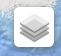 

In [5]:
Map = geemap.Map()
Map.add_basemap('SATELLITE')
Map.add_basemap('ROADMAP')
Map.add_basemap('Esri Ocean')
Map.add_basemap('Esri National Geographic')
Map

### WMS
Or we can add WMS and XYZ tile layers:

In [6]:
Map = geemap.Map()
# Add XYZ tiles
url = 'https://mt1.google.com/vt/lyrs=m&x={x}&y={y}&z={z}'
Map.add_tile_layer(url, name='Google Map', attribution='Google')
# Add WMS tiles
naip_url = 'https://services.nationalmap.gov/arcgis/services/USGSNAIPImagery/ImageServer/WMSServer?'
Map.add_wms_layer(url=naip_url, layers='0', name='NAIP Imagery', format='image/png', shown=True)
# For example last weeks example MODIS example
wv_url = 'https://gibs.earthdata.nasa.gov/wms/epsg4326/best/wms.cgi'
Map.add_wms_layer(url=wv_url,layers='VIIRS_SNPP_CorrectedReflectance_TrueColor',time='2021-04-01', name='MODIS')
# Or the PDOK imagery
pd_url = 'https://service.pdok.nl/hwh/luchtfotorgb/wms/v1_0'
Map.add_wms_layer(url=pd_url,layers='Actueel_ortho25',name='PDOK',shown=False)
Map

### GEE data
Or we can add GEE data ranging from images/image collections to geometries/features/feature collections.



#### Images vs. image collections
When processing data it is important to understand the difference between images and image collections. 
[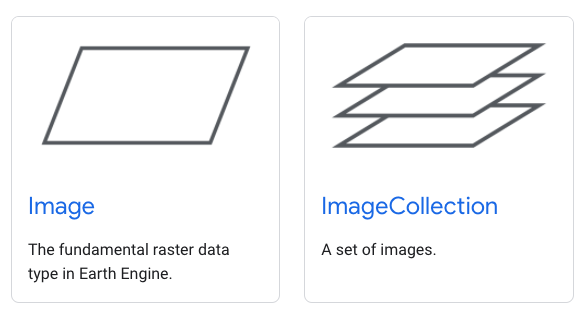](https://developers.google.com/earth-engine/guides/objects_methods_overview)

Images are individual rasters composed of one or more bands and each band has its own name, data type, scale, mask and projection. Each image has metadata stored as a set of properties. Images can be loaded by pasting an Earth Engine asset ID into the `ee.Image()` constructor. You can find image IDs in the [data catalog](https://developers.google.com/earth-engine/datasets). For example, to load the USGS SRTM:

In [7]:
# Define Earth Engine dataset
image = ee.Image('USGS/SRTMGL1_003')

Subsequently, we can add it to our Map by defining some visualization parameters. Here we are going to define only the min/max value to visualize, but you can find additional visualisation parameters [here](https://developers.google.com/earth-engine/guides/image_visualization).

In [8]:
# Set visualization parameters.
vis_params = {
  'min': 0,
  'max': 4000}

# Create Map
Map = geemap.Map()

# Add Earth Engine layers to Map
Map.addLayer(image, vis_params, 'DEM')

# Show map
Map

An ImageCollection is a stack or sequence of images. For example, it can be the entire [Sentinel-2 surface reflection collection]('https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR') which contains all Sentinel-2 surface reflectance images over the Earth.

An ImageCollection can be loaded by pasting an Earth Engine asset ID into the `ee.ImageCollection` constructor. You can find ImageCollection IDs in the [data catalog](https://developers.google.com/earth-engine/datasets). 

In [9]:
sentinelCollection = ee.ImageCollection('COPERNICUS/S2_SR');

This collection contains every Sentinel-2 image in the public catalog. There are a lot. Usually you want to filter the collection before. Filtering can occur based on:
 * region of interest / bounds:  to only get images that contain a certain area. Later we will see how to define such an area
 * date: to only get images from a certain date range
 * metadata: to only get images that fulfill a certain metadata requirement (e.g. only images with less than x% cloud cover). To get an idea of the potential metadata, I recommend to have a look at the data catalog -> `Image Properties` for each collection (e.g. for S2: https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR)

In [10]:
S2 = (ee.ImageCollection('COPERNICUS/S2_SR')
         .filterBounds(ee.Geometry.Point(4, 52))
         .filterDate('2019-01-01', '2019-12-31')
         .filterMetadata('CLOUDY_PIXEL_PERCENTAGE','less_than',20))

The standard way to get an image out of a collection is to reduce the collection. For example, we can sort based on a metadata field and subsequently get the first image. Notice in the following example that the image appears very dark as the min/max values are 0/10000 (corresponding to relfectance values of 0/1; see scale parameter in [data catalog](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR#bands)), but changing the max-value to a lower valuye will make it clearer.

In [18]:
# Sort and get first image
S2_im = S2.sort('CLOUDY_PIXEL_PERCENTAGE').first()
# Define vis parameters
S2_vis = {'bands':['B4','B3','B2'],
          'min':0,
          'max':10000}
# Initialize Map
Map = geemap.Map()
# Add image
Map.addLayer(S2_im,S2_vis,'S2 first image')
# Zoom map on image on scale level 10
Map.center_object(S2_im,10)

Map

Or apply some basic reduces to get the mean, median etc.

In [65]:
# Get the Mean image of the collection
S2_im = S2.mean()
# Get the Median image of the collection
S2_im2 = S2.median()

# Define vis parameters
S2_vis = {'bands':['B4','B3','B2'],
          'min':0,
          'max':4000}
# Initialize Map
Map = geemap.Map()
# Add image
Map.addLayer(S2_im,S2_vis,'S2 mean')
Map.addLayer(S2_im2,S2_vis,'S2 median')
Map


As you will notice, the `mean` and `median` image are rather different. Can you explain these differences?

#### Geometries in GEE
We can also define geometries in GEE as Earth Engine handles vector data with the Geometry type. GEE support points and polygons but in this example notebook we are going to limit ourselves to points and rectangles. By default these are defined in `EPSG:4326` so lat/lon coordinates. Subsequently we can use these geometries to filter our data or define an output geometry when exporting

In [129]:
# Point based on lon/lat
point = ee.Geometry.Point([1.5, 1.5])
# Rectangle based on (minLon, minLat, maxLon, maxLat).
rectangle = ee.Geometry.Rectangle([4.30,51.95,4.39,52])
# rectangle = ee.Geometry.Rectangle([4.38,51.2,4.9,52])

### Exporting from GEE
geemap also allows to export your data to your local computer using the `.ee_export_image` (for images) and `ee_export_image_collection` (for collections) functions.

To export, we always need to [define](https://geemap.org/common/#geemap.common.ee_export_image):
* `region`: a region of interest (bounding box)
*  `crs`: a coordinate reference system (i.e. projection where the data are exported in) 
* `scale`: the scale (in m) in which the data are exported
* `filename`: output filename for the exported image

To define a filename and folder structure, we need to consider the computer architecture we are working in (e.g., windows, Mac, Linux or Colab). If you are working on a local computer, you can get your local folder (e.g. `Downloads` folder) with:

In [119]:
# If on local computer
out_dir = os.path.join(os.path.expanduser('~'), 'Downloads')

If you want other specific folders, you can change the `Downloads` with your local folder. Remember that on Window subsfolder are separated by `\` and on Mac/Linux by `/` (e.g. `Downloads/subfolder1/subsubfolder2/`).

On a colab computer mounted to Google drive, your output directory should be `/content/drive/MyDrive` with potential subfolders to save it to your Drive.

In [160]:
# If on colab and you want to download to drive
out_dir = '/content/drive/MyDrive/'
# If on colab and you want to download it to the notebook storage only
out_dir = '/content/'

To define the output file, we need to append the desired output filename to the folder

In [66]:
filename = os.path.join(out_dir, 'S2_SR.tif')
print(filename)

/content/S2_SR.tif


And then we can start exporting. When we set `file_per_band=False` all image bands will be exported in one file. If you set it to `True`, each band will be saved to a different file with the band name appended. To understand what the different bands mean, I always recommend to check the data catalog of GEE before exporting.

In [122]:
geemap.ee_export_image(S2_im, filename=filename, scale=10, region=rectangle, file_per_band=False)

Generating URL ...
An error occurred while downloading.
Total request size (527640976 bytes) must be less than or equal to 33554432 bytes.


One of the drawbacks of GEE is that downloads are limited to ~33.5Mb and max 10000 pixel dimensions. To avoid hitting this limit, it is therefore wise to subset to only the bands you need by using the [`select` function](https://developers.google.com/earth-engine/apidocs/ee-image-select). For example, if you only want the RGB+NIR bands you can select `['B4','B3','B2','B8']`. Again I recommend to check the data catalog to understand what these bands mean.

If you hit the download limit it may also be wise to select/download per band.

In [130]:
geemap.ee_export_image(S2_im.select(['B4','B3','B2','B8']), filename=filename, scale=10, region=rectangle, crs='EPSG:3857', file_per_band=False)

Generating URL ...
Please wait ...
Data downloaded to /content/S2_SR.tif


Alternatively we can also download image collections using [`ee_export_image_collection`](https://geemap.org/common/#geemap.common.ee_export_image_collection). It is similar to exporting images, but now you only provide a folder you will download every image in your collection.

In [131]:
geemap.ee_export_image_collection(S2.select(['B4','B3','B2']), out_dir=out_dir, scale=10, region=rectangle, crs='EPSG:3857', file_per_band=False)

Total number of images: 31

Exporting 1/31: 20190215T105131_20190215T105128_T31UET.tif
Generating URL ...
Please wait ...
Data downloaded to /root/Downloads/20190215T105131_20190215T105128_T31UET.tif


Exporting 2/31: 20190223T110039_20190223T110040_T31UET.tif
Generating URL ...
Please wait ...
Data downloaded to /root/Downloads/20190223T110039_20190223T110040_T31UET.tif


Exporting 3/31: 20190225T105021_20190225T105315_T31UET.tif
Generating URL ...
Please wait ...
Data downloaded to /root/Downloads/20190225T105021_20190225T105315_T31UET.tif


Exporting 4/31: 20190305T110029_20190305T110032_T31UET.tif
Generating URL ...
Please wait ...
Data downloaded to /root/Downloads/20190305T110029_20190305T110032_T31UET.tif


Exporting 5/31: 20190330T105631_20190330T110608_T31UET.tif
Generating URL ...
Please wait ...
Data downloaded to /root/Downloads/20190330T105631_20190330T110608_T31UET.tif


Exporting 6/31: 20190401T105029_20190401T105221_T31UET.tif
Generating URL ...


KeyboardInterrupt: ignored

## Rasterio
Once the data are downloaded we can open them using `rasterio`. Rasterio reads and writes geospatial raster datasets. It employs GDAL under the hood for file I/O and raster formatting. Its functions typically accept and return Numpy ndarrays. Rasterio is designed to make working with geospatial raster data more productive and more fun.

Consider a GeoTIFF file named `S2_SR.tif` we just downloaded. We first need to open it with rasterio

In [132]:
dataset = rasterio.open(filename)

Rasterio’s open() function takes a path string or path-like object and returns an opened dataset object. The path may point to a file of any supported raster format. Rasterio will open it using the proper GDAL format driver. Dataset objects have some of the same attributes as Python file objects.

In [49]:
dataset.name

'/content/S2_SR.tif'

Properties of the raster data stored in the example GeoTIFF can be accessed through attributes of the opened dataset object. Dataset objects have bands and this example has a band count of 4 as our latest export were only RGB+NIR bands.

In [133]:
dataset.count

4

A dataset band is an array of values representing the partial distribution of a single variable in 2-dimensional (2D) space. All band arrays of a dataset have the same number of rows and columns.

In [134]:
print(dataset.width)
print(dataset.height)


1003
905


### Raster georeferencing
A GIS raster dataset is different from an ordinary image; its elements (or “pixels”) are mapped to regions on the earth’s surface. Every pixels of a dataset is contained within a spatial bounding box. In this case it are the coordinates in the output `crs` we defined when exporting.



In [94]:
dataset.bounds

BoundingBox(left=487570.0, bottom=6798310.0, right=488700.0, top=6800130.0)

In [53]:
dataset.crs

CRS.from_epsg(3857)

### Reading raster data
Data from a raster band can be accessed by the band’s index number. Following the GDAL convention, bands are indexed from 1 (and not 0 as in most python arrays)

In [70]:
band1 = dataset.read(1)

The read() method returns a Numpy N-D array.

In [71]:
band1

array([[666.7, 666.7, 666.7, ..., 692.8, 692.8, 692.8],
       [666.7, 666.7, 666.7, ..., 692.8, 692.8, 692.8],
       [656.8, 656.8, 656.8, ..., 692.8, 692.8, 692.8],
       ...,
       [544.6, 544.6, 544.6, ..., 762.7, 762.7, 654.6],
       [770.8, 770.8, 544.6, ..., 762.7, 762.7, 654.6],
       [770.8, 770.8, 770.8, ..., 762.7, 762.7, 654.6]])

Instead of reading single bands, all bands of the input dataset can also be read into a 3-dimensonal ndarray. Note that the interpretation of the 3 axes is `(bands, rows, columns)`. 

In [136]:
bands = dataset.read()
bands.shape

(4, 905, 1003)

The interpretation of a 3-dimension array read from rasterio is `(bands, rows, columns)` while image processing software like scikit-image, pillow and matplotlib are generally ordered as `(rows, columns, bands)` where number of rows defines the dataset’s height, the columns are the dataset’s width.

Numpy provides a way to efficiently swap the axis order and you can use the following reshape functions to convert between raster and image axis order:



In [135]:
from rasterio.plot import reshape_as_raster, reshape_as_image
# Convert to image
image = reshape_as_image(bands)
print(image.shape)
# Convert back to raster
raster = reshape_as_raster(image)
print(raster.shape)

(182, 113, 4)
(4, 182, 113)


Irrespective to the ordering, values from the array can be addressed by their `band, row, column` index. Notice that now indexing starts again at 0 as in classic python arrays

In [97]:
bands[0, 150, 100]

853.0

## Analyzing & plotting the data
Once the data are downloaded and opened, we can start analyzing and plotting them. For example, if we want to calculate the calculate the `NDVI` (see lectures), we need the normalized ration between R & NIR, which in our case are bands 0 and 3.



In [137]:
ndvi = (bands[0,:,:]-bands[3,:,:])/(bands[0,:,:]+bands[3,:,:])
ndvi

array([[-0.82196091, -0.81489075, -0.81489075, ..., -0.29976968,
        -0.52204335, -0.48793822],
       [-0.81381132, -0.80800134, -0.80800134, ..., -0.29976968,
        -0.29976968, -0.21694831],
       [-0.81381132, -0.80800134, -0.80800134, ..., -0.13388876,
        -0.13388876, -0.1115462 ],
       ...,
       [-0.84688339, -0.83660974, -0.83660974, ..., -0.67944697,
        -0.67085005, -0.67085005],
       [-0.81447008, -0.79749706, -0.79749706, ..., -0.67944697,
        -0.67085005, -0.67085005],
       [-0.81447008, -0.79749706, -0.79749706, ..., -0.65157925,
        -0.65075866, -0.65075866]])

We can off course also plot the data in a map using the mapping tools your learned last week

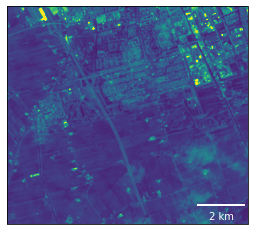

In [151]:
plt.figure()
crs=ccrs.epsg(3857)
ax = plt.axes(projection=crs)
img_extent = [dataset.bounds.left,dataset.bounds.right,dataset.bounds.bottom,dataset.bounds.top]
ax.set_extent(img_extent,crs=crs)
ax.imshow(bands[0,:,:],vmin=0,vmax=3000, extent=img_extent, origin='upper')
scalebar = ScaleBar(1,box_alpha=0,color='white',location='lower right')
ax.add_artist(scalebar)

Or show it as an image using the reshape_as_image function and by rescaling the data to 0-1 range. Remember that the original data are integerts that need rescaling anyway (see data catalog and scaling value)

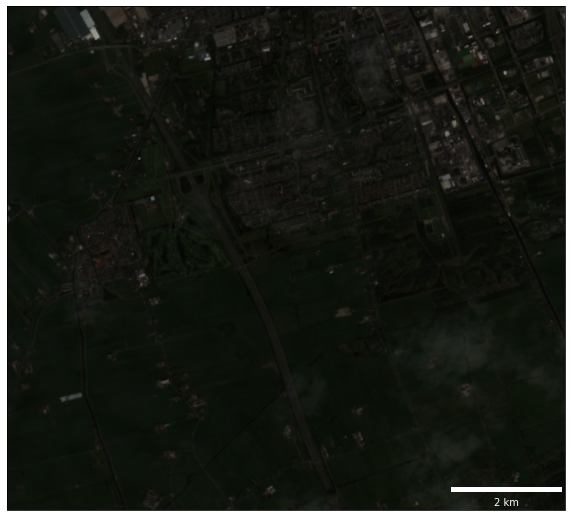

In [150]:
plt.figure(figsize=(10,10))
crs=ccrs.epsg(3857)
ax = plt.axes(projection=crs)
img_extent = [dataset.bounds.left,dataset.bounds.right,dataset.bounds.bottom,dataset.bounds.top]
ax.set_extent(img_extent,crs=crs)
ax.imshow(reshape_as_image(bands)[:,:,0:3]/10000., extent=img_extent, origin='upper')
scalebar = ScaleBar(1,box_alpha=0,color='white',location='lower right')
ax.add_artist(scalebar)

This image is still rather dark. To understand why, you can plot a histogram of the band values.

Text(0, 0.5, 'Probability density by counts')

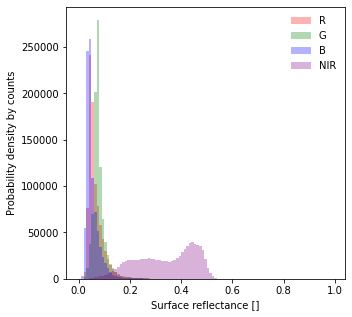

In [145]:
# First rescale the values to reflectance values
im = bands/10000. # see the data catalog where the scale value is 0.0001
# Plot
plt.figure(figsize=(5, 5))
ax = plt.axes()
ax.hist(im[0,:,:].flatten(),bins=np.arange(0, 1, 0.01),color='red',alpha=0.3,label='R')
ax.hist(im[1,:,:].flatten(),bins=np.arange(0, 1, 0.01),color='green',alpha=0.3,label='G')
ax.hist(im[2,:,:].flatten(),bins=np.arange(0, 1, 0.01),color='blue',alpha=0.3,label='B')
ax.hist(im[3,:,:].flatten(),bins=np.arange(0, 1, 0.01),color='purple',alpha=0.3,label='NIR')
ax.legend(frameon=False,fontsize=10)
ax.set_xlabel('Surface reflectance []')
ax.set_ylabel('Probability density by counts')

The figure shows that for the RGB bands the reflectance values are indeed rather low (`<0.2`) resulting in a dark image. If we plot a false color `NIR/R/G` composite, we can indeed see that most of the image turns red as a result of the stronger reflectance of vegetation in the NIR band.

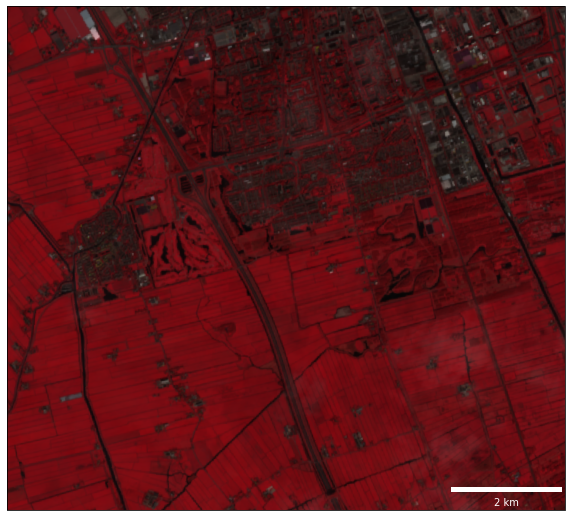

In [152]:
plt.figure(figsize=(10,10))
crs=ccrs.epsg(3857)
ax = plt.axes(projection=crs)
img_extent = [dataset.bounds.left,dataset.bounds.right,dataset.bounds.bottom,dataset.bounds.top]
ax.set_extent(img_extent,crs=crs)
ax.imshow(reshape_as_image(bands)[:,:,(3,0,1)]/10000., extent=img_extent, origin='upper')
scalebar = ScaleBar(1,box_alpha=0,color='white',location='lower right')
ax.add_artist(scalebar)

If we want to adjust the scaling, we can just apply offset and scaling values to increase brightness or contrast (see lecture slides).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


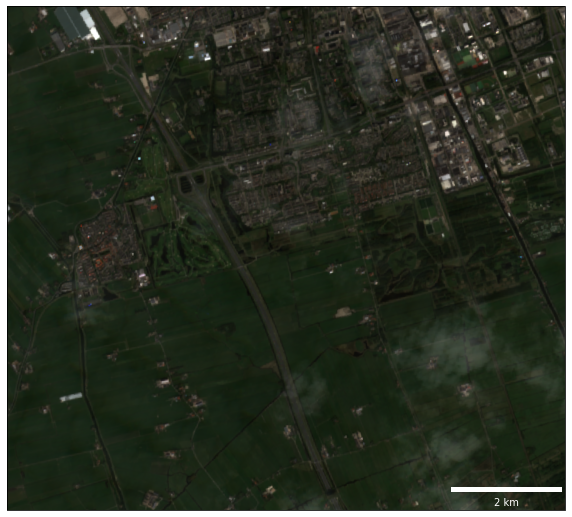

In [153]:
image = reshape_as_image(bands)/10000.*2
plt.figure(figsize=(10,10))
crs=ccrs.epsg(3857)
ax = plt.axes(projection=crs)
img_extent = [dataset.bounds.left,dataset.bounds.right,dataset.bounds.bottom,dataset.bounds.top]
ax.set_extent(img_extent,crs=crs)
ax.imshow(image[:,:,0:3], extent=img_extent, origin='upper')
scalebar = ScaleBar(1,box_alpha=0,color='white',location='lower right')
ax.add_artist(scalebar)

When  we can visualize one image, we can off course als visualize change. This can be done just making different subplots  and showing different images next to eachother, but also by making an animation. We can do this by looping over all the images, creating a plot and subsequently combining them in a video.

First start by looping over all downloaded images. We can use this by using the `glob2` function which allows to search for all files that correspond to a certain filename. For example, if we want all `tif` files in our `out_dir` we can do:

In [162]:
glob2.glob(out_dir+'*tif')

['/content/20190330T105631_20190330T110608_T31UET.tif',
 '/content/20190901T105619_20190901T110617_T31UET.tif',
 '/content/20190424T105629_20190424T105847_T31UET.tif',
 '/content/20190705T105031_20190705T105032_T31UET.tif',
 '/content/20190511T105039_20190511T105205_T31UET.tif',
 '/content/20190730T105039_20190730T105502_T31UET.tif',
 '/content/20190411T105029_20190411T105100_T31UET.tif',
 '/content/20190223T110039_20190223T110040_T31UET.tif',
 '/content/20190414T105629_20190414T105704_T31UET.tif',
 '/content/20190723T105629_20190723T105718_T31UET.tif',
 '/content/20191110T110159_20191110T110202_T31UET.tif',
 '/content/20190215T105131_20190215T105128_T31UET.tif',
 '/content/20190524T105629_20190524T110120_T31UET.tif',
 '/content/20190401T105029_20190401T105221_T31UET.tif',
 '/content/20190807T105621_20190807T110430_T31UET.tif',
 '/content/20190703T105629_20190703T110536_T31UET.tif',
 '/content/S2_SR.tif',
 '/content/20190421T105039_20190421T105033_T31UET.tif',
 '/content/20191031T11010

Or get only the files from our collection that start with a `2`.

In [163]:
glob2.glob(out_dir+'2*tif')

['/content/20190330T105631_20190330T110608_T31UET.tif',
 '/content/20190901T105619_20190901T110617_T31UET.tif',
 '/content/20190424T105629_20190424T105847_T31UET.tif',
 '/content/20190705T105031_20190705T105032_T31UET.tif',
 '/content/20190511T105039_20190511T105205_T31UET.tif',
 '/content/20190730T105039_20190730T105502_T31UET.tif',
 '/content/20190411T105029_20190411T105100_T31UET.tif',
 '/content/20190223T110039_20190223T110040_T31UET.tif',
 '/content/20190414T105629_20190414T105704_T31UET.tif',
 '/content/20190723T105629_20190723T105718_T31UET.tif',
 '/content/20191110T110159_20191110T110202_T31UET.tif',
 '/content/20190215T105131_20190215T105128_T31UET.tif',
 '/content/20190524T105629_20190524T110120_T31UET.tif',
 '/content/20190401T105029_20190401T105221_T31UET.tif',
 '/content/20190807T105621_20190807T110430_T31UET.tif',
 '/content/20190703T105629_20190703T110536_T31UET.tif',
 '/content/20190421T105039_20190421T105033_T31UET.tif',
 '/content/20191031T110109_20191031T110230_T31UE

Subsequently, we can loop over these files.

/content/20190330T105631_20190330T110608_T31UET.tif 20190330
Saving to /content/outf_20190330.png
/content/20190901T105619_20190901T110617_T31UET.tif 20190901
Saving to /content/outf_20190901.png
/content/20190424T105629_20190424T105847_T31UET.tif 20190424
Saving to /content/outf_20190424.png
/content/20190705T105031_20190705T105032_T31UET.tif 20190705
Saving to /content/outf_20190705.png
/content/20190511T105039_20190511T105205_T31UET.tif 20190511
Saving to /content/outf_20190511.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/20190730T105039_20190730T105502_T31UET.tif 20190730
Saving to /content/outf_20190730.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/20190411T105029_20190411T105100_T31UET.tif 20190411
Saving to /content/outf_20190411.png
/content/20190223T110039_20190223T110040_T31UET.tif 20190223
Saving to /content/outf_20190223.png
/content/20190414T105629_20190414T105704_T31UET.tif 20190414
Saving to /content/outf_20190414.png
/content/20190723T105629_20190723T105718_T31UET.tif 20190723
Saving to /content/outf_20190723.png
/content/20191110T110159_20191110T110202_T31UET.tif 20191110
Saving to /content/outf_20191110.png
/content/20190215T105131_20190215T105128_T31UET.tif 20190215
Saving to /content/outf_20190215.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/20190524T105629_20190524T110120_T31UET.tif 20190524
Saving to /content/outf_20190524.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/20190401T105029_20190401T105221_T31UET.tif 20190401
Saving to /content/outf_20190401.png
/content/20190807T105621_20190807T110430_T31UET.tif 20190807
Saving to /content/outf_20190807.png
/content/20190703T105629_20190703T110536_T31UET.tif 20190703
Saving to /content/outf_20190703.png
/content/20190421T105039_20190421T105033_T31UET.tif 20190421
Saving to /content/outf_20190421.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/20191031T110109_20191031T110230_T31UET.tif 20191031
Saving to /content/outf_20191031.png
/content/20190827T105621_20190827T110526_T31UET.tif 20190827
Saving to /content/outf_20190827.png
/content/20190305T110029_20190305T110032_T31UET.tif 20190305
Saving to /content/outf_20190305.png
/content/20190824T105031_20190824T105344_T31UET.tif 20190824
Saving to /content/outf_20190824.png


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/20190419T105621_20190419T110407_T31UET.tif 20190419
Saving to /content/outf_20190419.png
/content/20191230T110349_20191230T110347_T31UET.tif 20191230
Saving to /content/outf_20191230.png
/content/20190429T105621_20190429T110224_T31UET.tif 20190429
Saving to /content/outf_20190429.png
/content/20190725T105031_20190725T105032_T31UET.tif 20190725
Saving to /content/outf_20190725.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/20190514T105629_20190514T105747_T31UET.tif 20190514
Saving to /content/outf_20190514.png
/content/20190529T105621_20190529T110302_T31UET.tif 20190529
Saving to /content/outf_20190529.png
/content/20190628T105621_20190628T110225_T31UET.tif 20190628
Saving to /content/outf_20190628.png
/content/20190822T105629_20190822T105624_T31UET.tif 20190822
Saving to /content/outf_20190822.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/20190225T105021_20190225T105315_T31UET.tif 20190225
Saving to /content/outf_20190225.png
/content/20190921T105739_20190921T110218_T31UET.tif 20190921
Saving to /content/outf_20190921.png


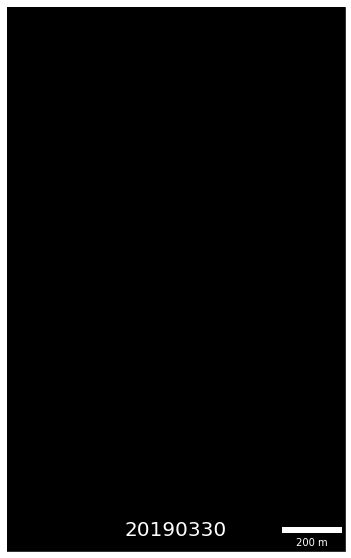

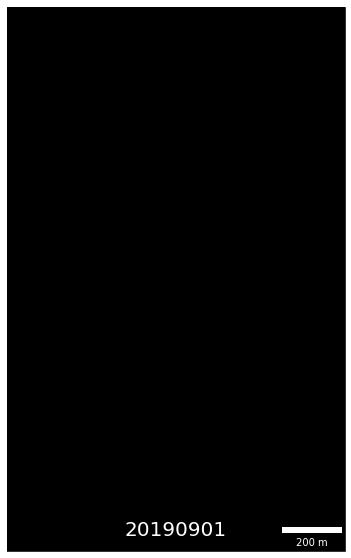

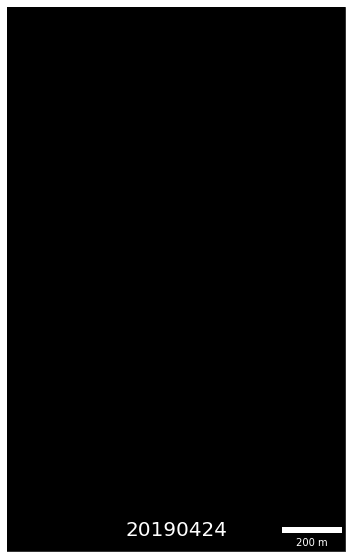

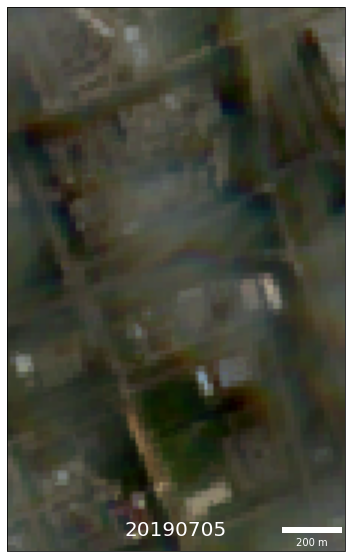

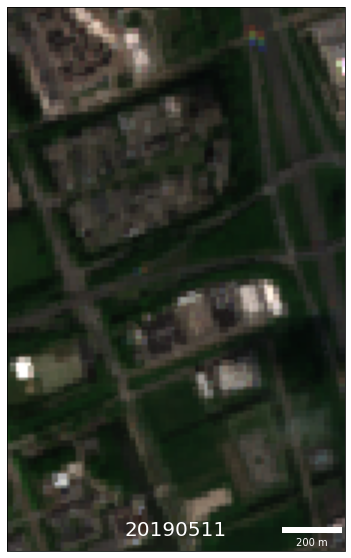

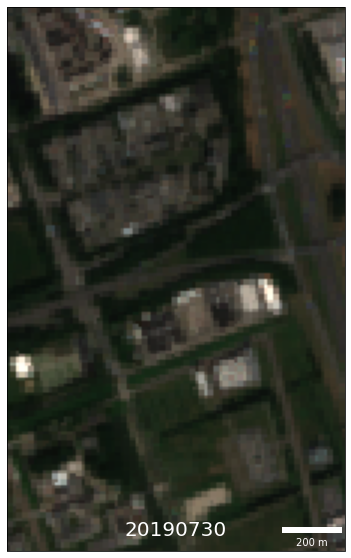

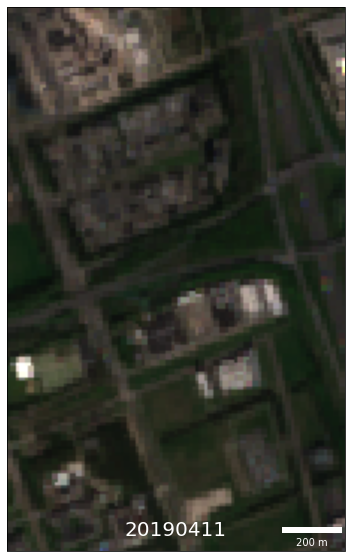

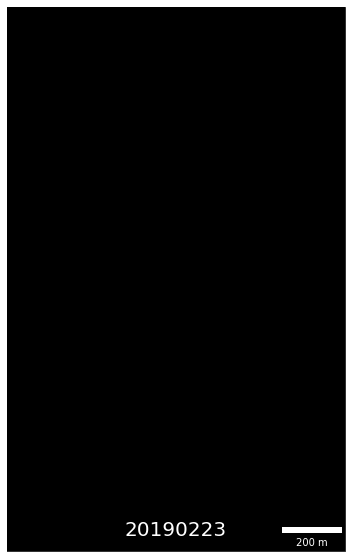

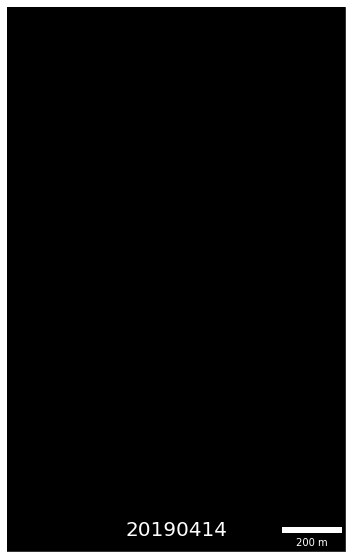

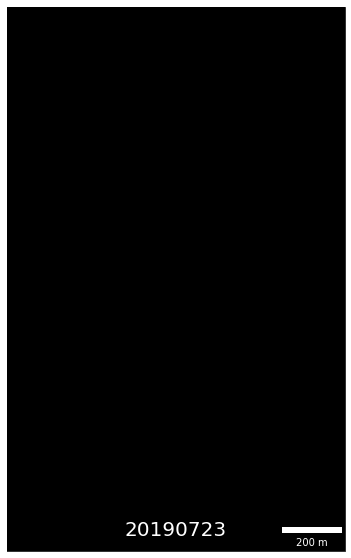

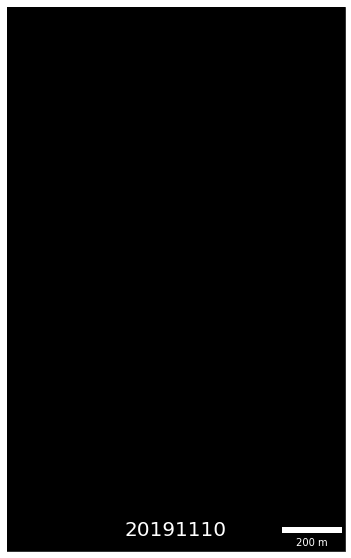

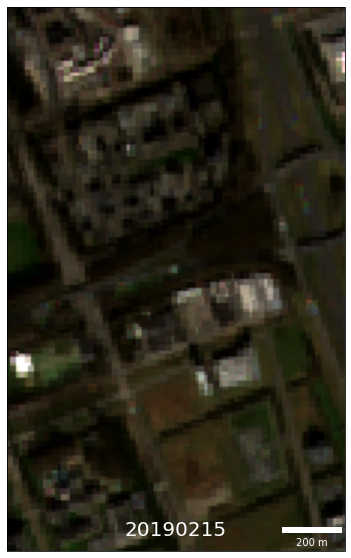

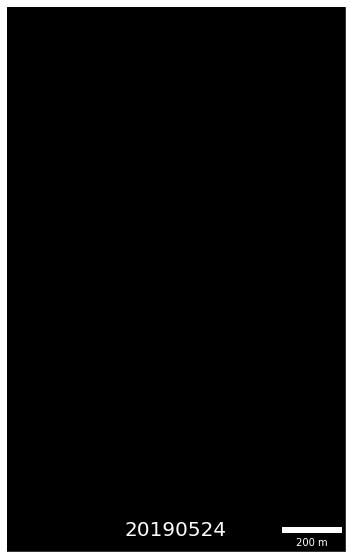

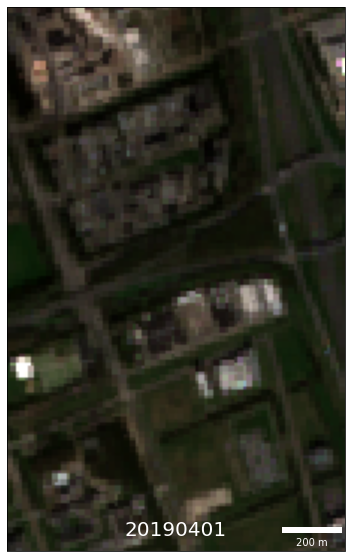

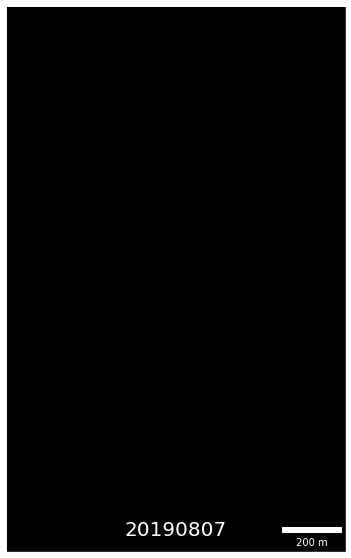

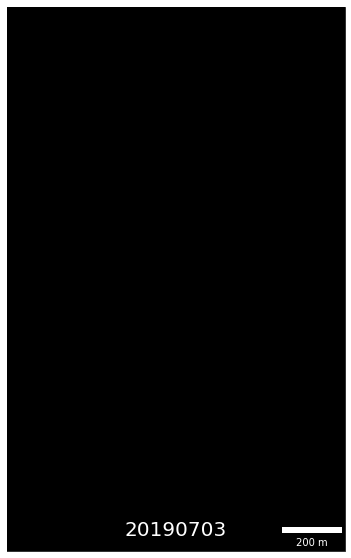

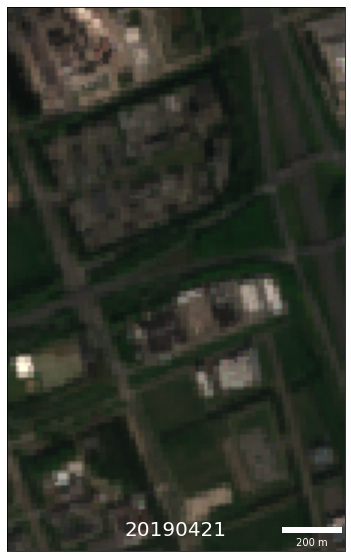

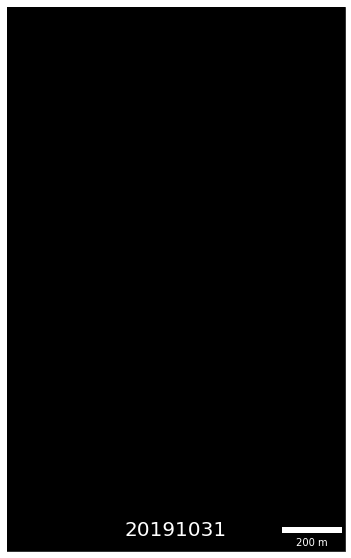

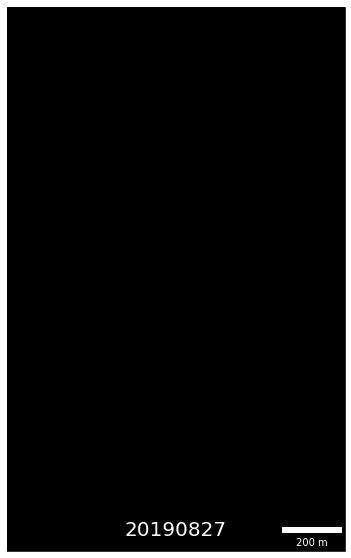

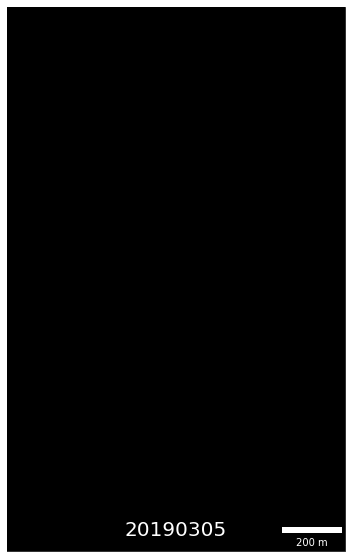

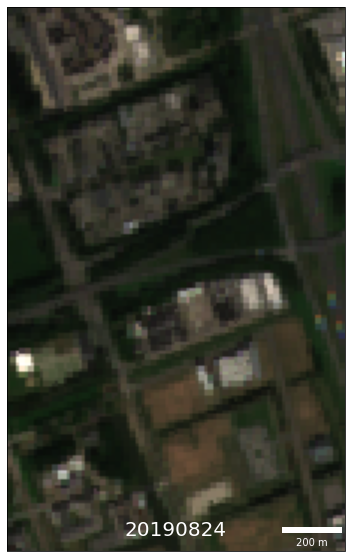

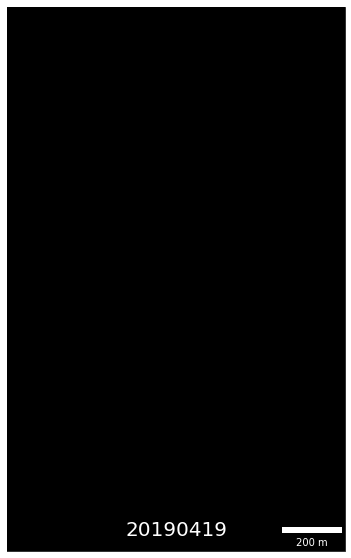

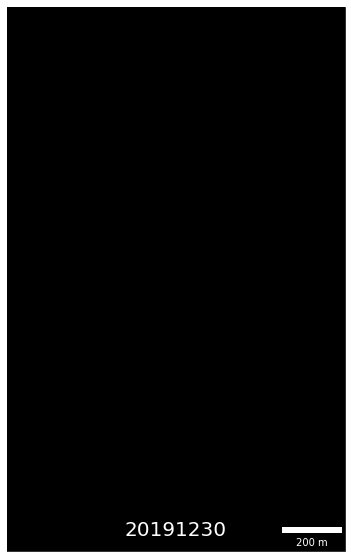

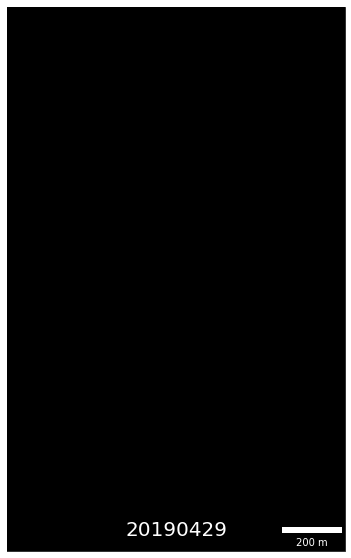

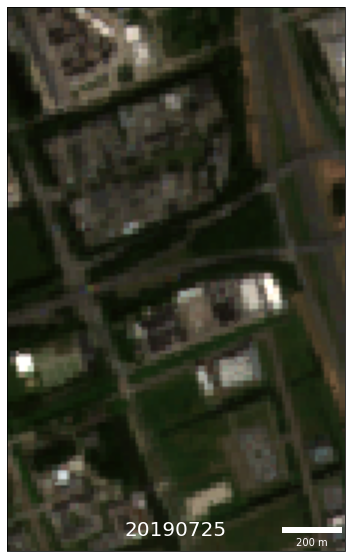

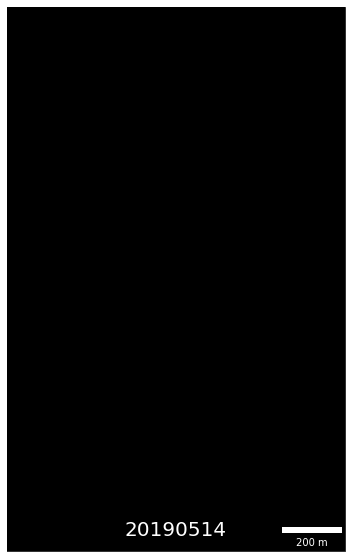

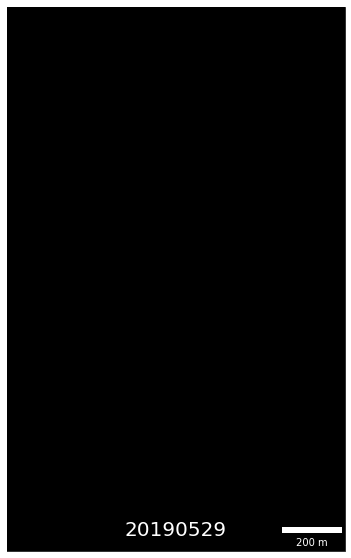

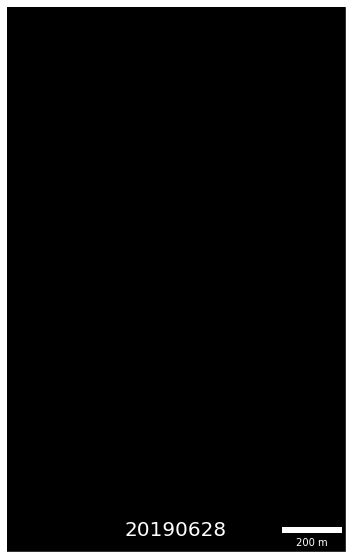

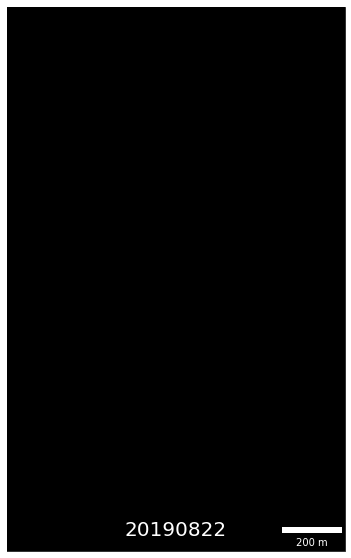

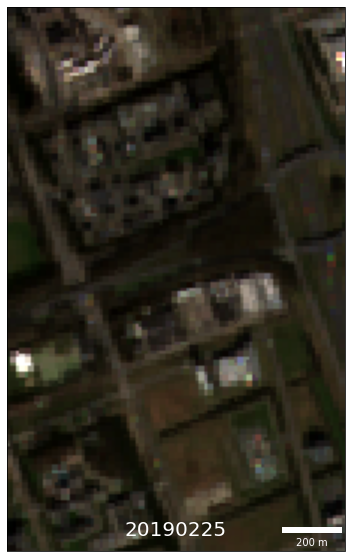

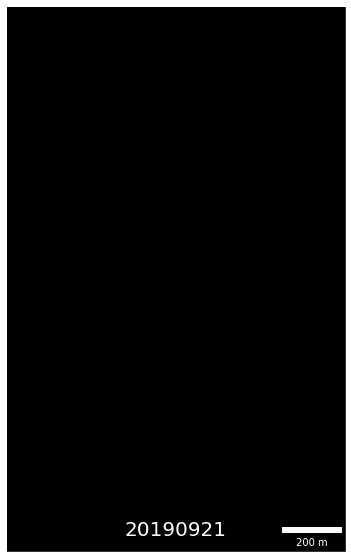

In [177]:
filelist=glob2.glob(out_dir+'2*tif')
for file in filelist:
  # Get date from filename using the 10th to 17th character
  date = file[9:17]
  print(file,date)
  # Set output filename
  outf= os.path.join(out_dir, 'outf_'+date+'.png')
  print('Saving to',outf)

  # Open file
  dataset = rasterio.open(file)
  # Read data
  bands = dataset.read()
  # Convert to reflectance and rescale
  image = reshape_as_image(bands)/10000.*2
  # Plot
  plt.figure(figsize=(10,10))
  crs=ccrs.epsg(3857)
  ax = plt.axes(projection=crs)
  img_extent = [dataset.bounds.left,dataset.bounds.right,dataset.bounds.bottom,dataset.bounds.top]
  ax.set_extent(img_extent,crs=crs)
  ax.imshow(image[:,:,0:3], extent=img_extent, origin='upper')
  # Add text to the plot
  plt.text(0.5, 0.02, date, horizontalalignment='center', verticalalignment='bottom', transform=ax.transAxes,size=20, color='white')
  # Add scalebar
  scalebar = ScaleBar(1,box_alpha=0,color='white',location='lower right')
  ax.add_artist(scalebar)
  # Save as png file
  plt.savefig(outf, bbox_inches='tight', dpi=150,pad_inches=0,transparent=True)



Now we have plotted all images and saved them to a `png` file in our out_dir. As you will see, there are still some bad frames (e.g. containing missing data. We can then manually remove them (e.g. by deleting them) and the convert them into a gif.

In [178]:
# First make an empty list of images
images = []
# Make a new list of all the frames based on glob and read each file
for filename in sorted(glob2.glob(out_dir+'*'+'outf*png')):
    images.append(imageio.imread(filename))
# Convert to a gif
out_filename = os.path.join(out_dir, 'movie.gif')
imageio.mimsave('movie.gif', images, fps=2)

# Done
With these ingredients, you should be able to do the analyses of Notebook 2. Good luck!